# Lecture 4 - Multivariate Time Series Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests

In [2]:
# surpress warnings
import warnings
warnings.filterwarnings("ignore")

## Load Data
### Beijing Multi Site Air Quality

In [3]:
path='Data_sets/Beijing_Air_Quality.csv'

# Load the dataset into a pandas DataFrame
bjn_a_q_data = pd.read_csv(path)#, parse_dates=['time'], index_col='time')

# Convert the year, month, day, hour columns to a datetime index
bjn_a_q_data['datetime'] = pd.to_datetime(bjn_a_q_data[['year', 'month', 'day', 'hour']])

# Set the datetime column as the index
bjn_a_q_data.set_index('datetime', inplace=True)

# Drop the year, month, day, hour and No columns
bjn_a_q_data.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)

# set bjn_a_q_data frequency to hourly
bjn_a_q_data = bjn_a_q_data.asfreq('H')

# explore the data
print(bjn_a_q_data.info())
bjn_a_q_data.head()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Freq: h
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2.5    34139 non-null  float64
 1   PM10     34346 non-null  float64
 2   SO2      34129 non-null  float64
 3   NO2      34041 non-null  float64
 4   CO       33288 non-null  float64
 5   O3       33345 non-null  float64
 6   TEMP     35044 non-null  float64
 7   PRES     35044 non-null  float64
 8   DEWP     35044 non-null  float64
 9   RAIN     35044 non-null  float64
 10  wd       34983 non-null  object 
 11  WSPM     35050 non-null  float64
 12  station  35064 non-null  object 
dtypes: float64(11), object(2)
memory usage: 3.7+ MB
None


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


## Pre-Proccess and Visualize  


### Handle Missing Values

In [4]:
bjn_df = bjn_a_q_data.copy()
# Drop the columns with non numeric values
bjn_df.drop(columns=['station','wd'], inplace=True)

# Count the number of missing values by columns
missing_values = bjn_df.isnull().sum()
print('missing values by columns:', missing_values)

# count number of rows with missing values
missing_value_rows = bjn_df.isnull().sum(axis=1)
missing_value_rows = missing_value_rows[missing_value_rows > 0].count()
print('\n number of rows with missing values:', missing_value_rows)

# Since PM2.5 is the target variable, we will drop the rows with missing values in the PM2.5 column
bjn_df.dropna(subset=['PM2.5'], inplace=True)

# Count the number of leftover missing values by columns
missing_values = bjn_df.isnull().sum()
print('\n leftover missing values by columns:', missing_values)

# most of missing values are left in the CO and O3 columns
# Fill the missing values in the remaining columns with forward fill
bjn_df.fillna(method='ffill', inplace=True)

print(bjn_df.info())


missing values by columns: PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
WSPM       14
dtype: int64

 number of rows with missing values: 3188

 leftover missing values by columns: PM2.5       0
PM10        9
SO2       282
NO2       363
CO       1115
O3       1067
TEMP       20
PRES       20
DEWP       20
RAIN       20
WSPM       14
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34139 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   34139 non-null  float64
 1   PM10    34139 non-null  float64
 2   SO2     34139 non-null  float64
 3   NO2     34139 non-null  float64
 4   CO      34139 non-null  float64
 5   O3      34139 non-null  float64
 6   TEMP    34139 non-null  float64
 7   PRES    34139 non-null  float64
 8   DEWP    34139 non-null  float64
 9   RA

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

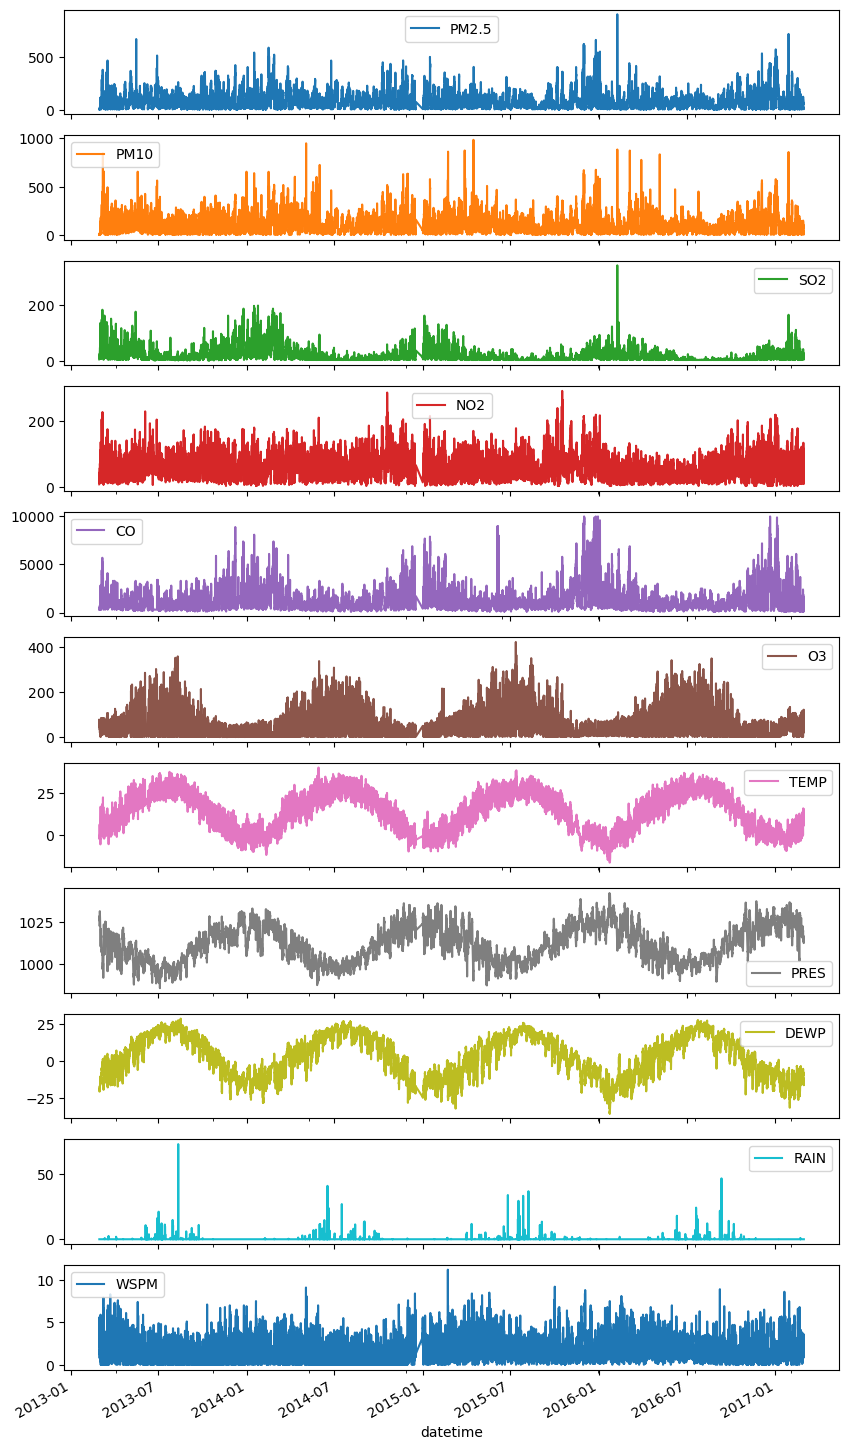

In [5]:
bjn_df.plot(subplots=True, figsize=(10, 20))

### Resample the data

In [6]:
# print data start and end date
print('Start date:', bjn_df.index.min())
print('End date:', bjn_df.index.max())

Start date: 2013-03-01 00:00:00
End date: 2017-02-28 23:00:00


#### Resample Daily Average data
To eliminate hourly and daily fluctoations that are non-relevant on a yearly cycle

data_daily.shape: (1446, 11)
                 PM2.5        PM10        SO2         NO2           CO  \
datetime                                                                 
2013-03-01    7.125000   10.750000  11.708333   22.583333   429.166667   
2013-03-02   30.750000   42.083333  36.625000   66.666667   824.916667   
2013-03-03   76.916667  120.541667  61.291667   81.000000  1620.625000   
2013-03-04   22.708333   44.583333  23.541667   45.500000   604.166667   
2013-03-05  148.875000  183.791667  93.875000  132.833333  2357.958333   

                   O3      TEMP         PRES       DEWP  RAIN      WSPM  
datetime                                                                 
2013-03-01  63.875000  1.391667  1026.875000 -18.745833   0.0  3.254167  
2013-03-02  29.750000  0.616667  1026.850000 -15.937500   0.0  1.479167  
2013-03-03  19.125000  5.566667  1014.608333 -12.316667   0.0  1.658333  
2013-03-04  53.750000  9.962500  1017.650000 -11.683333   0.0  2.404167  
2013-03-

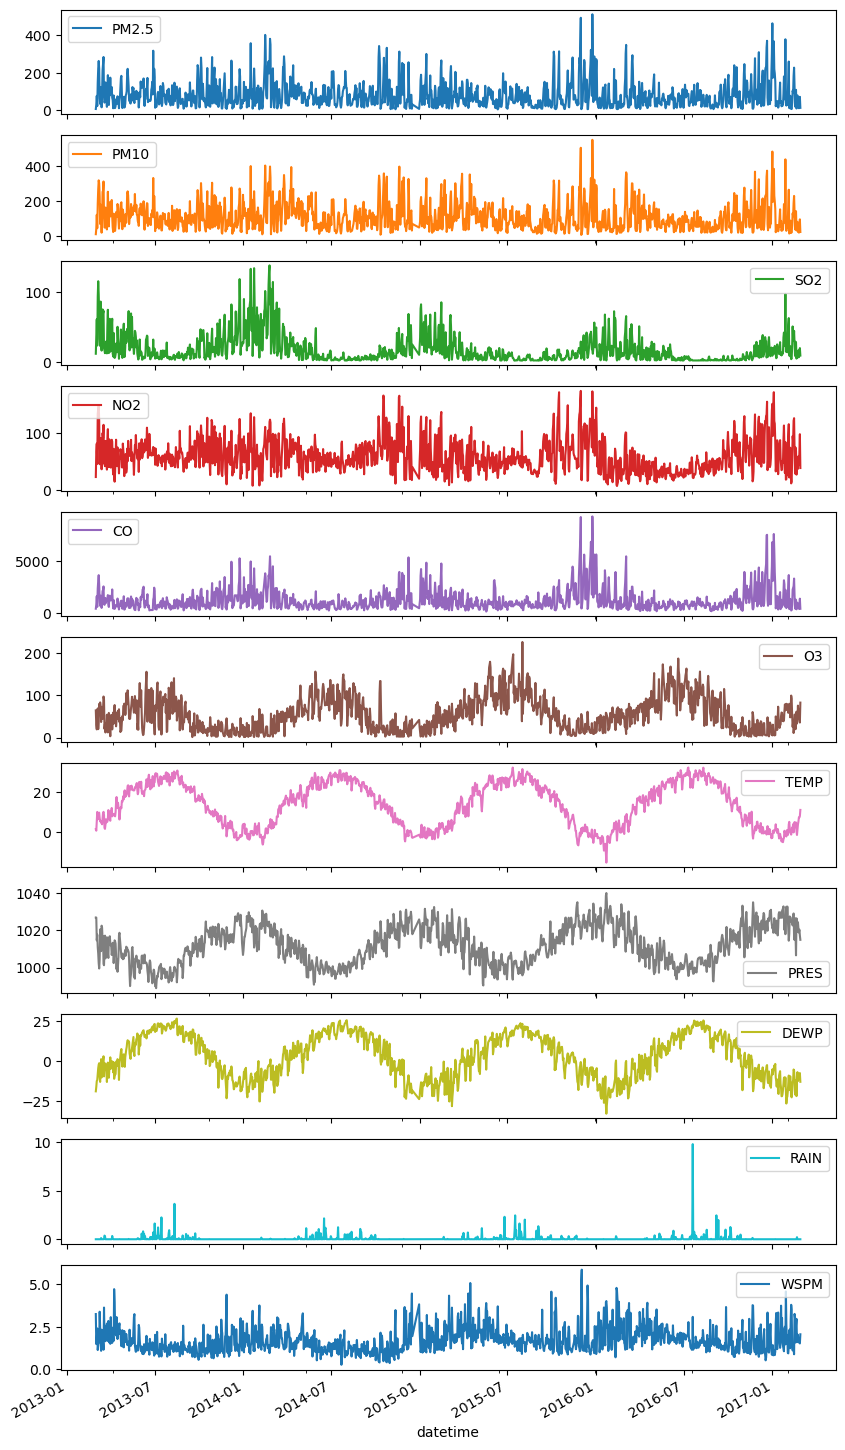

In [10]:
# creat a daily avrege form for the data
data_daily = bjn_df.resample('D').mean()  # 'D' stands for daily
data_daily.dropna(inplace=True)
data_daily = data_daily.asfreq('D') # set frequency to daily
data_daily.dropna(inplace=True)
print('data_daily.shape:', data_daily.shape)
print(data_daily.head())

# plot some of the numeric columns on the same figure
data_daily.plot(subplots=True, figsize=(10, 20))
plt.show()

### Check for stationarity

In [11]:
# Function to perform the ADF test
def adf_test(series, title=''): 
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {title}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

In [12]:
# Perform ADF test on key columns
# columns_to_test = ['PM2.5', 'TEMP', 'O3']
for column in data_daily.columns:
    adf_test(data_daily[column], title=column)

ADF Statistic for PM2.5
p-value: 4.682694126148706e-30
Stationary
ADF Statistic for PM10
p-value: 1.5122138726638695e-29
Stationary
ADF Statistic for SO2
p-value: 0.0011453819718833388
Stationary
ADF Statistic for NO2
p-value: 0.00043026412107179937
Stationary
ADF Statistic for CO
p-value: 0.007682383852836615
Stationary
ADF Statistic for O3
p-value: 0.17755829968590353
Non-Stationary
ADF Statistic for TEMP
p-value: 0.30399564786004274
Non-Stationary
ADF Statistic for PRES
p-value: 0.18015490593719802
Non-Stationary
ADF Statistic for DEWP
p-value: 0.4078015241403351
Non-Stationary
ADF Statistic for RAIN
p-value: 0.0
Stationary
ADF Statistic for WSPM
p-value: 0.007435902193364556
Stationary


### Differencing

In [13]:
# Difference the data
data_daily_diff = data_daily.diff().dropna()

## Cross-Correlation Function (CCF)

### Direct Correlation Matrix

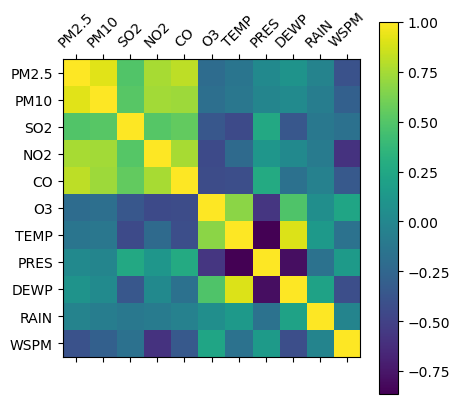

In [14]:
# Plot Correlation matrix of the data
plt.matshow(data_daily.corr())
plt.xticks(range(data_daily.shape[1]), data_daily.columns, fontsize=10, rotation=45)
plt.yticks(range(data_daily.shape[1]), data_daily.columns, fontsize=10)
plt.colorbar()
plt.show()

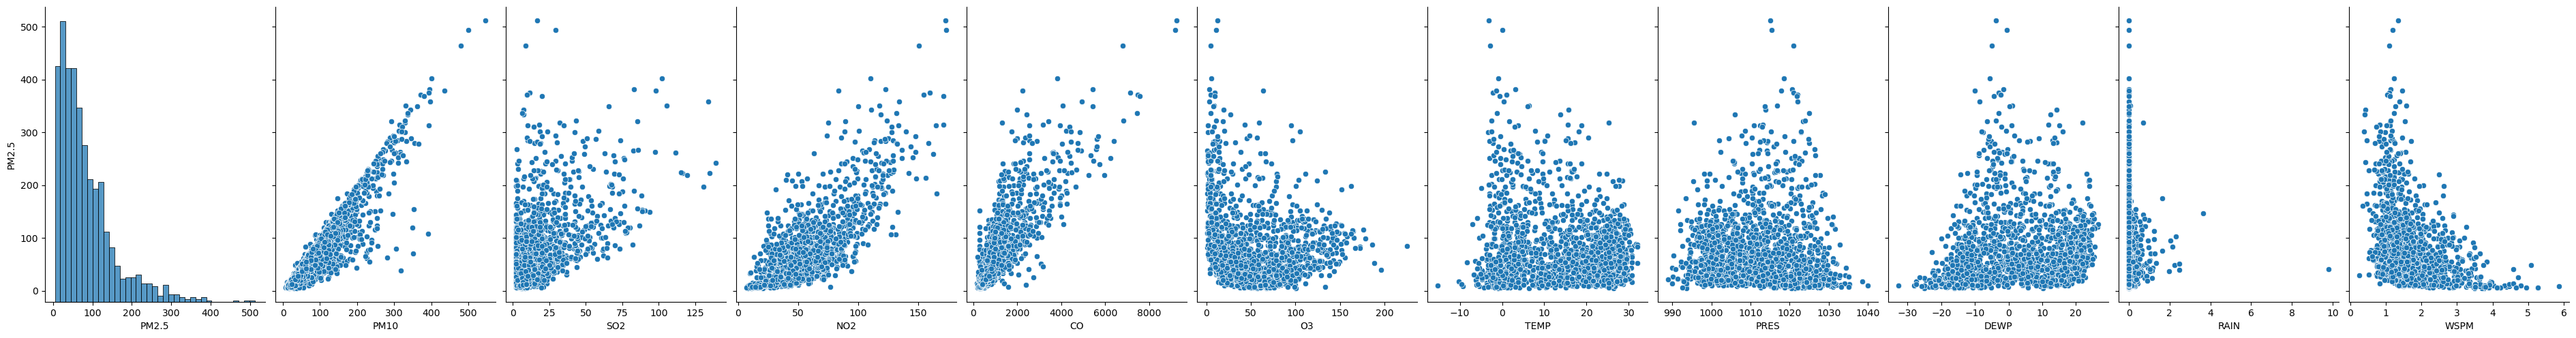

In [31]:
# Basic correlogram
#sns.pairplot(data_daily)
sns.pairplot(data_daily, y_vars=['PM2.5'], x_vars= data_daily.columns, height=5, aspect=0.7)
plt.show()

### Function to execute CCF on all variables (define target variable) and plot the results

In [36]:
# Function to execute CCF on all variables (relative to defined target variable) and plot the results

def calculate_and_plot_ccf(data_df, interest_column, nlag=None):
    # Initialize an empty dictionary to store ccf values
    ccf_values = {}

    # Iterate over each column in the DataFrame except the interest column
    for column in data_df.drop(columns=interest_column).columns:
        
        # Calculate the cross-correlation and store it in the dictionary
        ccf_values[column] = ccf(data_df[interest_column], data_df[column], nlags=nlag)

        # Plot the cross-correlation as vertical lines
        plt.figure(figsize=(7, 2))
        lags = range(len(ccf_values[column]))  # Assuming ccf returns an array-like structure
        plt.vlines(lags, 0, ccf_values[column])
        plt.plot(lags, ccf_values[column], marker='o', linestyle='None')
        plt.ylim(-1, 1)
        plt.title(f'Cross-correlation of {interest_column} with {column}')
        plt.xlabel('Lag')
        plt.ylabel('Cross-correlation')
        plt.show()

    # Create a DataFrame from the ccf_values
    ccf_df = pd.DataFrame(ccf_values)
    return ccf_df

#### CCF for Original daily data

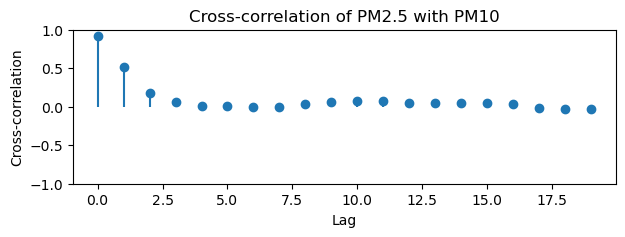

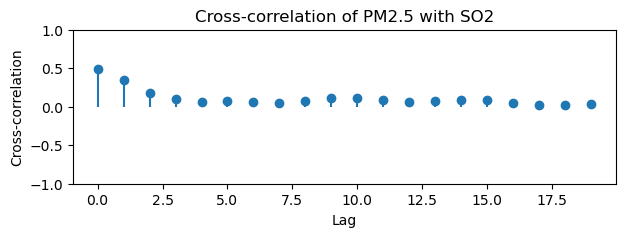

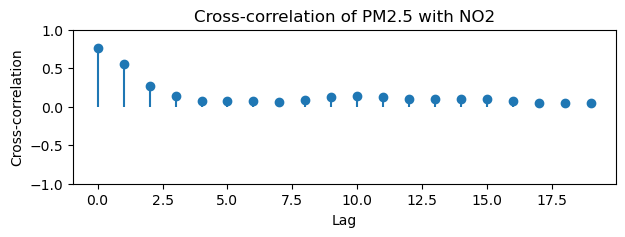

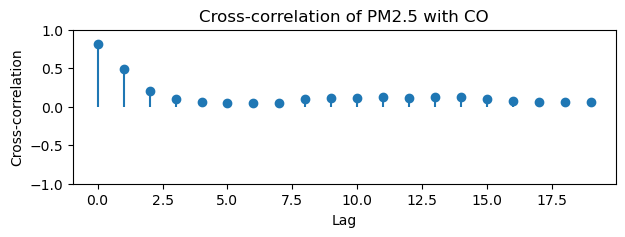

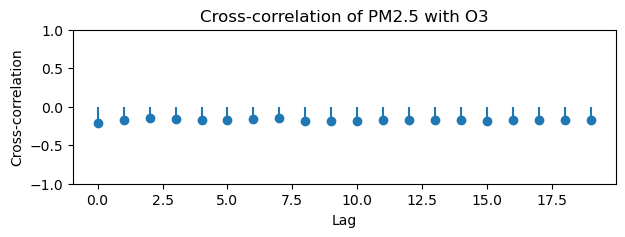

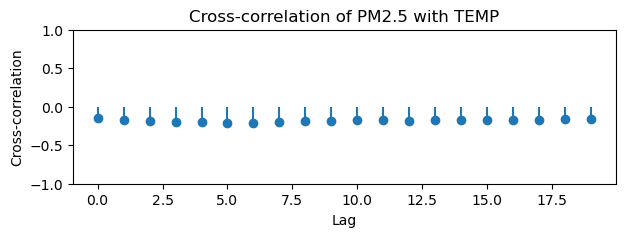

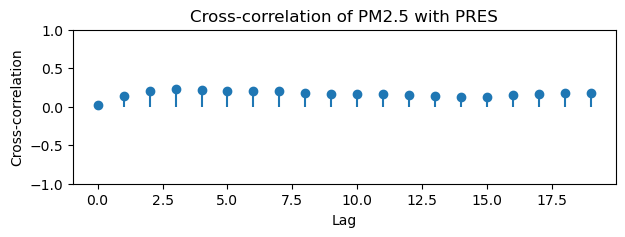

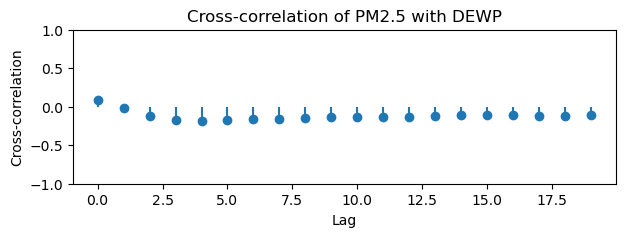

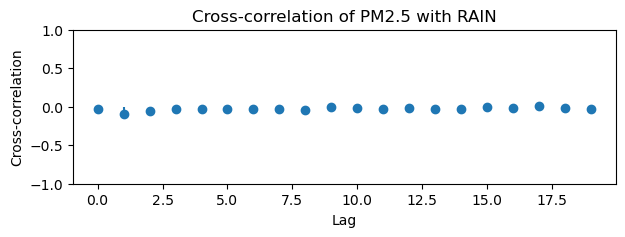

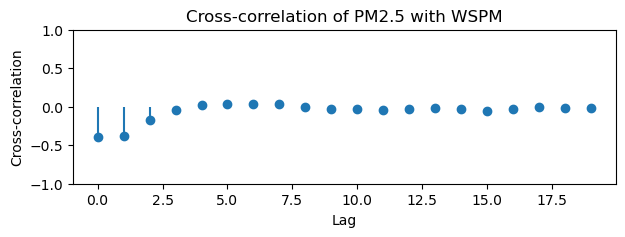

In [37]:
ccf_plot=calculate_and_plot_ccf(data_df=data_daily, interest_column='PM2.5', nlag=20)

#### CCF for Differenced data

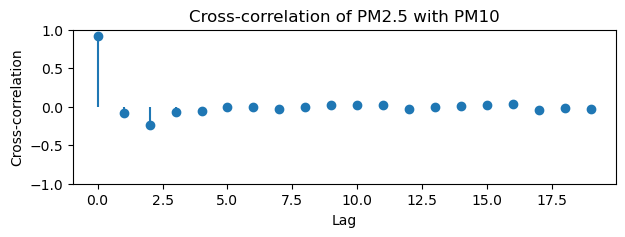

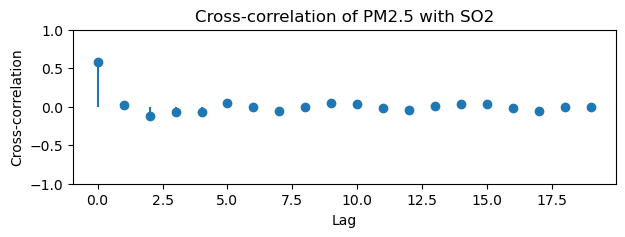

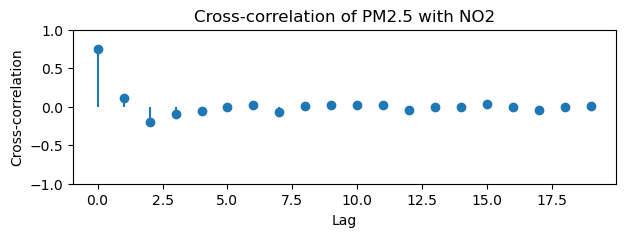

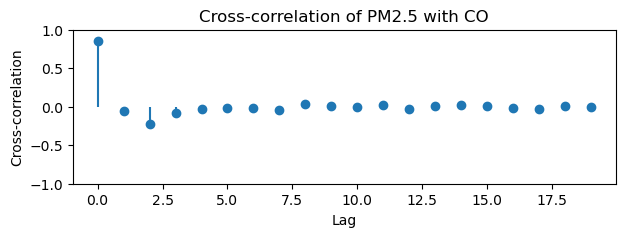

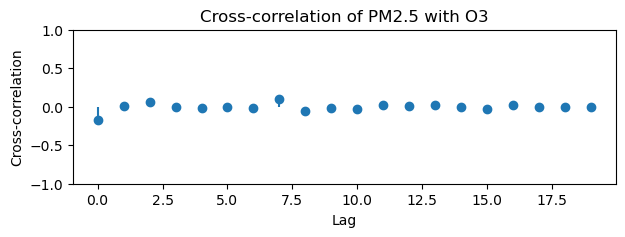

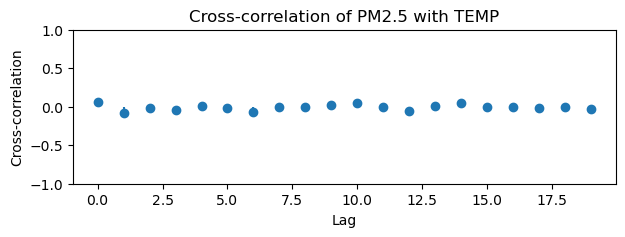

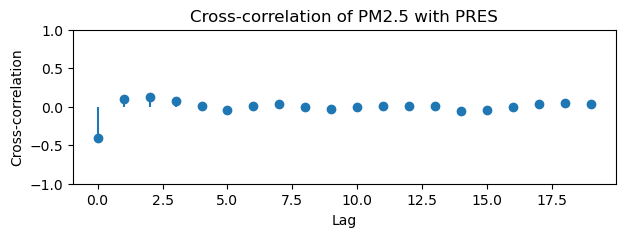

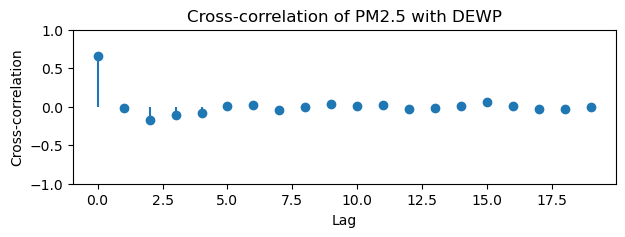

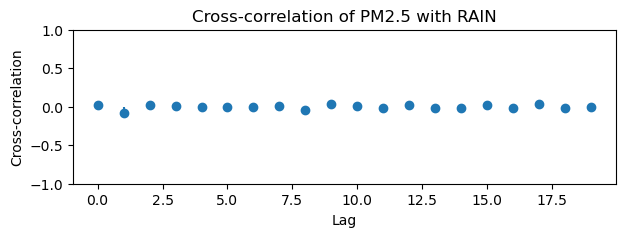

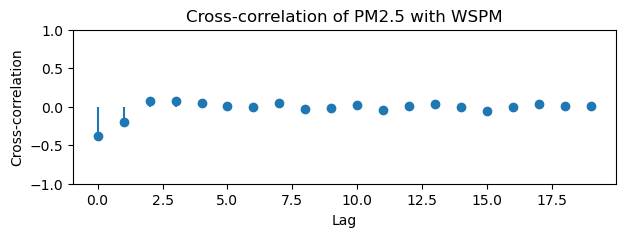

In [38]:
ccf_plot=calculate_and_plot_ccf(data_df=data_daily_diff, interest_column='PM2.5', nlag=20)

## Granger Causality Test

In [39]:
# Granger Causality test
# set parameters
data_set= data_daily
target_column = 'PM2.5'
test_column = 'CO'
num_lags = 20

# Perform Granger Causality test
# Null hypothesis: 'test_column' does not Granger-cause 'target_column'
granger_test_result = grangercausalitytests(data_set[[target_column, test_column]], maxlag=num_lags, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0191 , p=0.0016  , df_denom=1442, df_num=1
ssr based chi2 test:   chi2=10.0400 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0053 , p=0.0016  , df=1
parameter F test:         F=10.0191 , p=0.0016  , df_denom=1442, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7274  , p=0.0033  , df_denom=1439, df_num=2
ssr based chi2 test:   chi2=11.4947 , p=0.0032  , df=2
likelihood ratio test: chi2=11.4492 , p=0.0033  , df=2
parameter F test:         F=5.7274  , p=0.0033  , df_denom=1439, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7141  , p=0.0112  , df_denom=1436, df_num=3
ssr based chi2 test:   chi2=11.1965 , p=0.0107  , df=3
likelihood ratio test: chi2=11.1533 , p=0.0109  , df=3
parameter F test:         F=3.7141  , p=0.0112  , df_denom=1436, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9945  , p=0.

### Display the test results on figure

In [40]:
# Function to plot Granger Causality test results

def plot_granger_causality(data_set, target_column, test_column, num_lags, figsize=(8, 2)):
    # Perform Granger Causality test
    granger_test_result = grangercausalitytests(data_set[[target_column, test_column]], maxlag=num_lags, verbose=False)

    # set lags as a vector 1 to num_lags
    lags = range(1, num_lags + 1)   
    f_stats = [granger_test_result[lag][0]['ssr_ftest'][0] for lag in lags]
    p_values = [granger_test_result[lag][0]['ssr_ftest'][1] for lag in lags]

    # Plotting the F-statistics
    plt.figure(figsize=figsize)
    plt.vlines(lags, 0, f_stats, color='blue')  # Draw vertical lines
    plt.plot(lags, f_stats, 'bo')
    plt.title(f'Granger Causality F-statistics for {test_column} causing {target_column}')
    plt.xlabel('Lag')
    plt.ylabel('F-statistic')
    plt.grid(True)
    plt.show()

    # Plotting the p-values
    plt.figure(figsize=figsize)
    plt.vlines(lags, 0, p_values, color='red')  # Draw vertical lines
    plt.plot(lags, p_values, 'ro')  # 'ro' specifies red color and circle marker
    plt.axhline(y=0.05, color='green', linestyle='--')  # significance level
    plt.title(f'Granger Causality p-values for {test_column} causing {target_column}')
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.show()

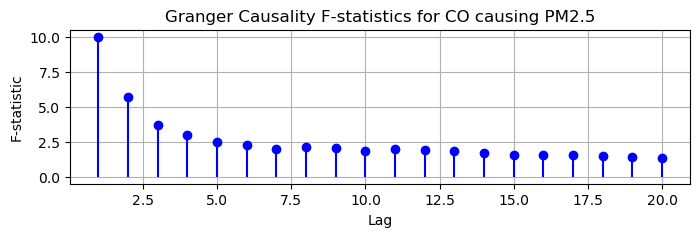

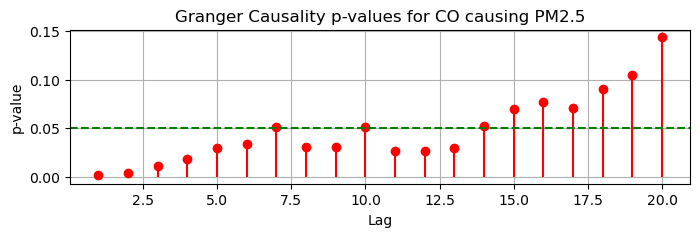

In [41]:
plot_granger_causality(data_set=data_daily, target_column='PM2.5', test_column='CO', num_lags=20)

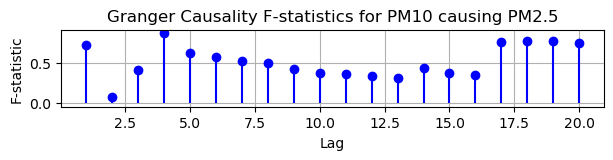

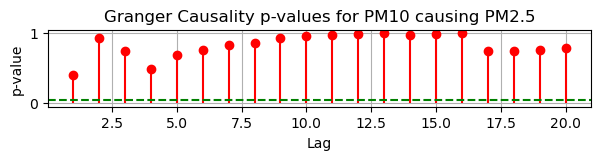

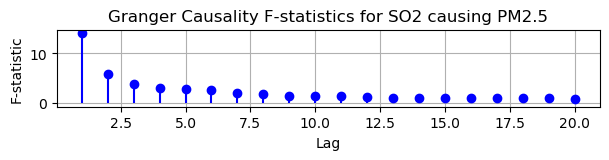

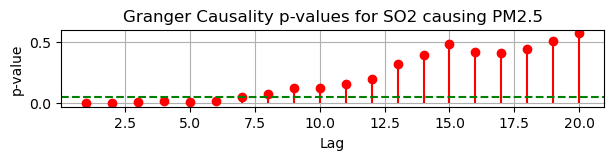

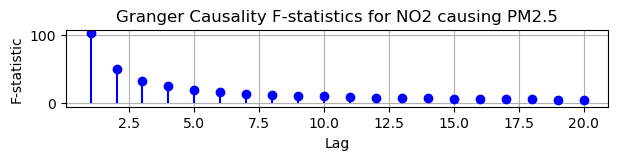

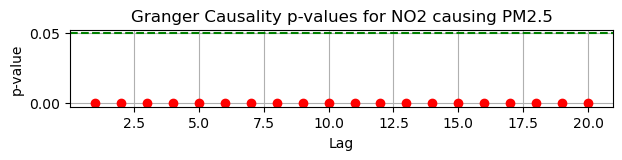

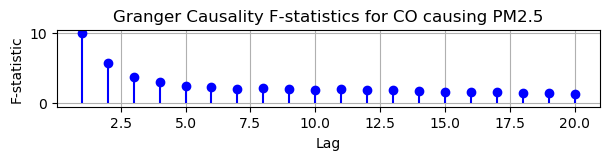

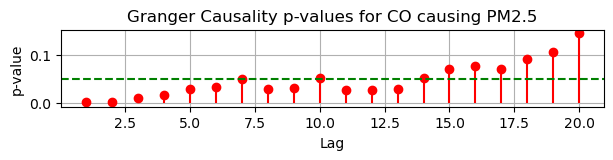

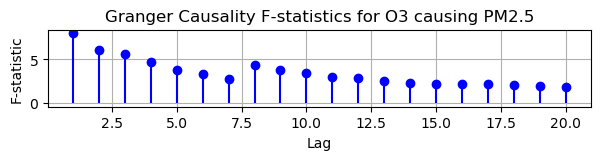

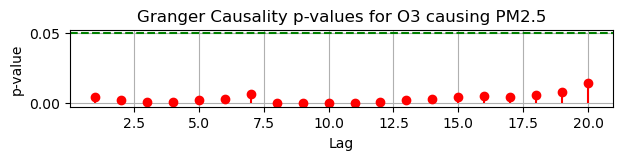

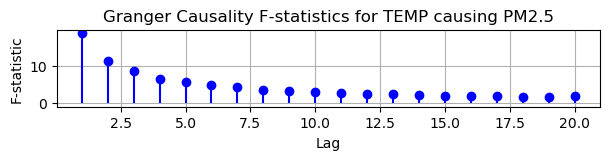

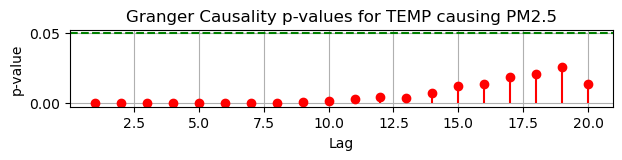

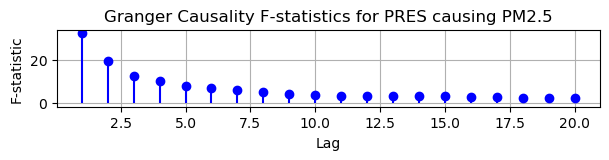

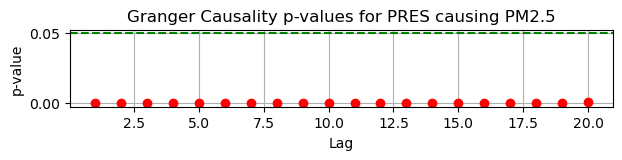

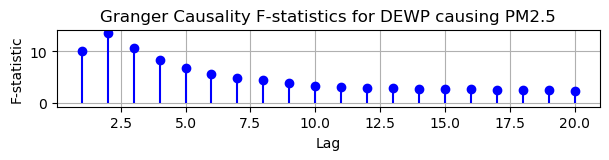

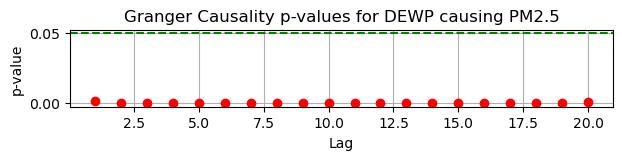

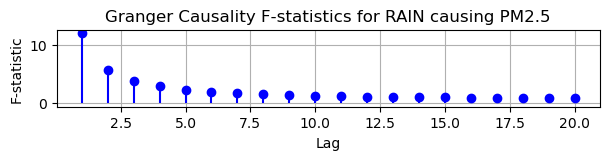

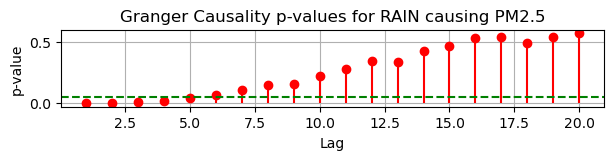

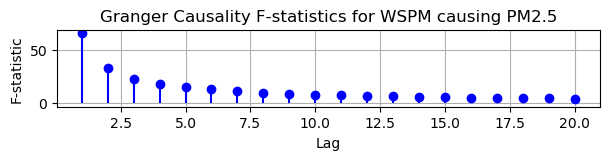

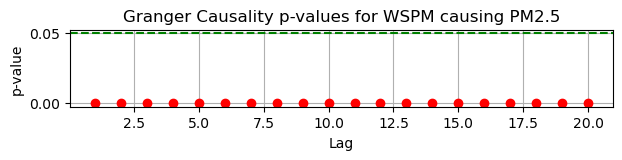

In [42]:
# itarate over all columns exept the target and perform granger causality test
traget = 'PM2.5'
data_set = data_daily
num_lags = 20

# Iterate over each column in the DataFrame except the target column
for column in data_set.drop(columns=traget).columns:
    plot_granger_causality(data_set=data_set, target_column=traget, test_column=column, num_lags=num_lags, figsize=(7, 1))

#### Granger Causality Test on the Differenced data
Here, we use it to identify significant predictors for PM2.5.

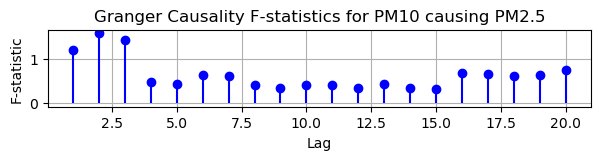

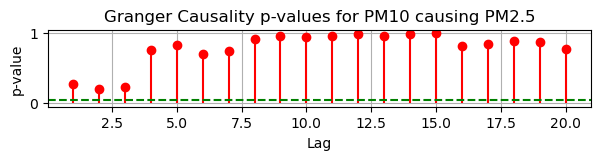

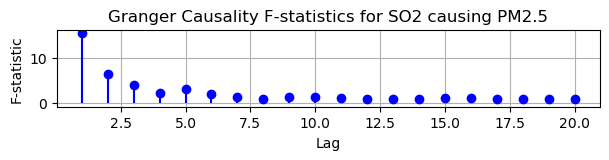

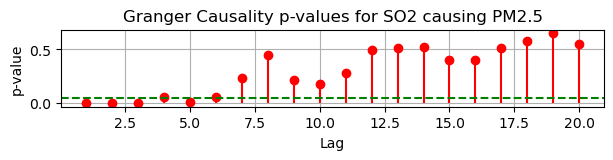

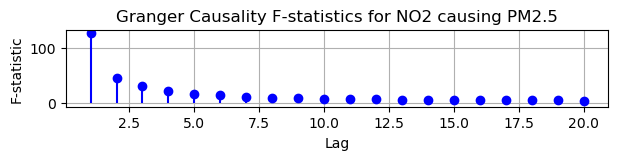

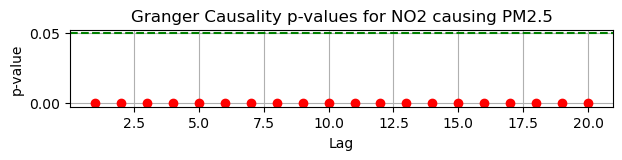

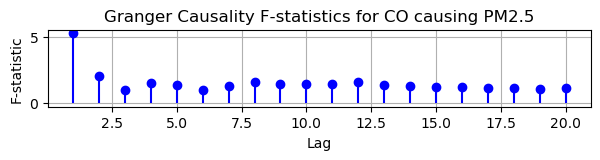

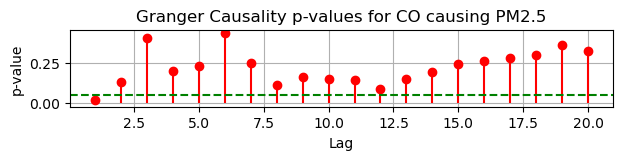

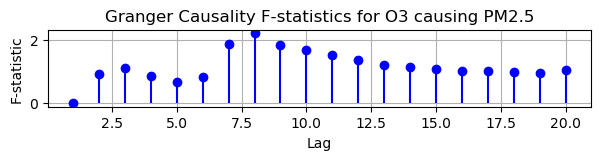

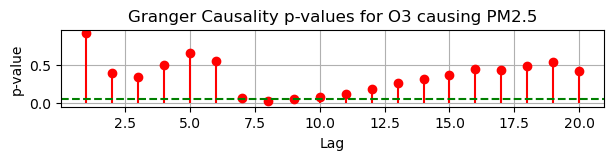

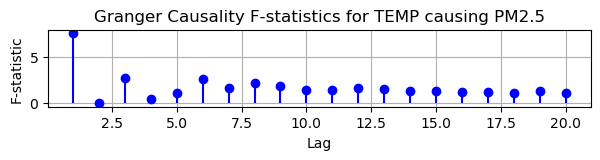

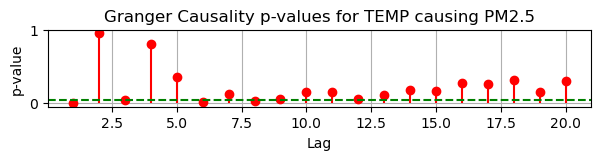

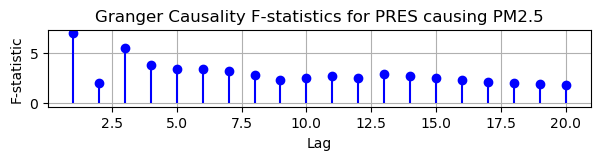

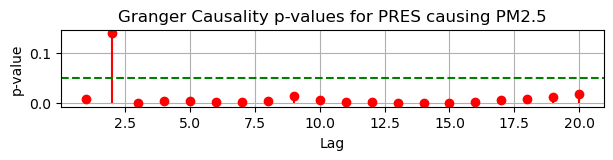

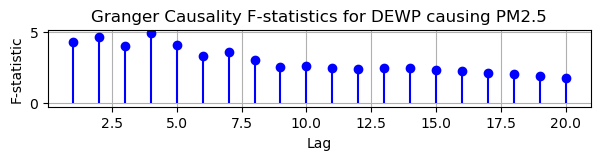

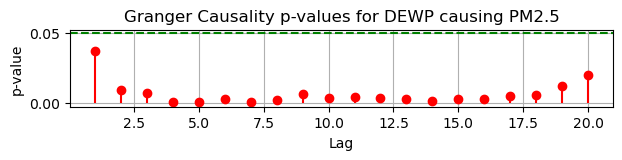

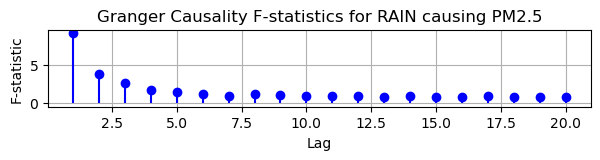

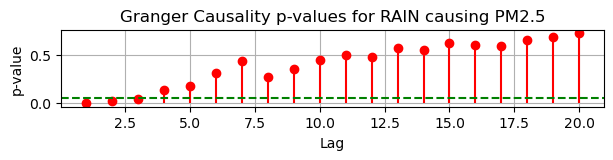

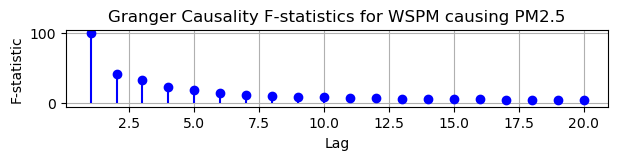

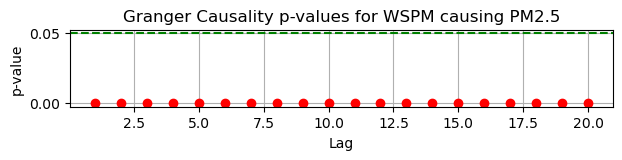

In [43]:
# itarate over all columns exept the target and perform granger causality test
traget = 'PM2.5'
data_set = data_daily_diff
num_lags = 20

# Iterate over each column in the DataFrame except the target column
for column in data_set.drop(columns=traget).columns:
    plot_granger_causality(data_set=data_set, target_column=traget, test_column=column, num_lags=num_lags, figsize=(7, 1))

- Selected predictors based on granger causality - NO2, O3, Pres, DewP, WSPM

In [44]:
selected_predictors= ['NO2', 'O3', 'PRES', 'DEWP', 'WSPM']

## VAR- Vector Auto Regression model

In [45]:
from statsmodels.tsa.api import VAR

In [46]:
# Split the data into train and test sets based on specified proportion
def split_data(df, test_prop= 0.1):

    test_size = int(test_prop * len(df))
    train, test = df[:-test_size], df[-test_size:]

    print('train shape:', train.shape)
    print('test shape:', test.shape)
    print('split Date:', train.index.max())
    return train, test, test_size

#### Prapare data for VAR model

In [47]:
data_set = data_daily
target = 'PM2.5'

# slelect the relevant features columns
model_data = data_set[selected_predictors + [target]]

# split to train and test
train, test, test_size = split_data(model_data, test_prop=0.1)

train shape: (1302, 6)
test shape: (144, 6)
split Date: 2016-10-07 00:00:00


### Select lag order

In [48]:
model = VAR(train)
lag_order_results = model.select_order(maxlags=10)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        28.21       28.23   1.782e+12       28.22
1        22.52       22.69   6.037e+09       22.58
2        22.35      22.66*   5.100e+09       22.47
3        22.25       22.71   4.616e+09      22.42*
4        22.23       22.83   4.527e+09       22.46
5       22.22*       22.96  4.473e+09*       22.50
6        22.22       23.11   4.487e+09       22.56
7        22.23       23.26   4.493e+09       22.61
8        22.24       23.41   4.553e+09       22.68
9        22.26       23.57   4.631e+09       22.75
10       22.27       23.74   4.721e+09       22.82
--------------------------------------------------


- AIC (Akaike Information Criterion)
- BIC (Bayesian Information Criterion)
- FPE (Final Prediction Error)
- HQIC (Hannan-Quinn Information Criterion) 

Lower values indicate better model performance for each of these criteria
(*) highlights the minimum value for each criterion

Choosing the Lag Length:

Lag 2: Preferred by BIC 

Lag 5: Preferred by AIC and FPE

### Fit the VAR model using the selected lag length (on differenced data)

In [49]:
model = VAR(train)
# Fit the VAR model using the selected lag length (6 in this case)
selected_lag = 2
var_model_fitted = model.fit(selected_lag)

# Display the summary of the fitted model
var_model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Oct, 2024
Time:                     21:56:32
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    22.6931
Nobs:                     1300.00    HQIC:                   22.4992
Log likelihood:          -25538.6    FPE:                5.25714e+09
AIC:                      22.3828    Det(Omega_mle):     4.95246e+09
--------------------------------------------------------------------
Results for equation NO2
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const         -464.435524       110.623828           -4.198           0.000
L1.NO2           0.760751         0.048781           15.595           0.000
L1.O3            0.154109         0.027634            5.577           0.000
L1.PRE

### Forecasting and Evaluating the results
- the model uses a recursive multi-step forecasting strategy
- Evaluating using RMSE

In [50]:
def plot_actual_vs_forecast(test, forecast_df, target):
    
    plt.figure(figsize=(8, 3))
    #plt.plot(train.index, train[target], label='Test')
    plt.plot(test.index, test[target], label='Test')
    plt.plot(forecast_df.index, forecast_df[target], label='Forecast')
    plt.legend()
    plt.title(f'{target} Actual vs Forecast values')
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(test[target], forecast_df[target]))
    
    # Print RMSE on the plot
    plt.text(test.index.min(), test[target].max(), f'RMSE: {rmse:.2f}', fontsize=12)
    plt.show()

In [52]:
# Forecast using the fitted model
forecast_values = var_model_fitted.forecast(train.values[-selected_lag:], steps=len(test)) # initial values are the last laged values of the train set
forecast_df = pd.DataFrame(forecast_values, index=test.index, columns=train.columns)
forecast_df.head()

,NO2,O3,PRES,DEWP,WSPM,PM2.5
datetime,,,,,,
2016-10-08,57.788846,22.617386,1012.733585,9.981137,1.487871,52.970270
2016-10-09,65.171432,33.207370,1011.138072,9.894408,1.419765,72.017252
2016-10-10,67.085905,41.386134,1010.387023,9.708461,1.435382,82.906744
2016-10-11,66.248026,47.101660,1010.101497,9.343171,1.474424,85.880394
2016-10-12,64.727979,51.005158,1009.965610,8.943987,1.512928,85.552269


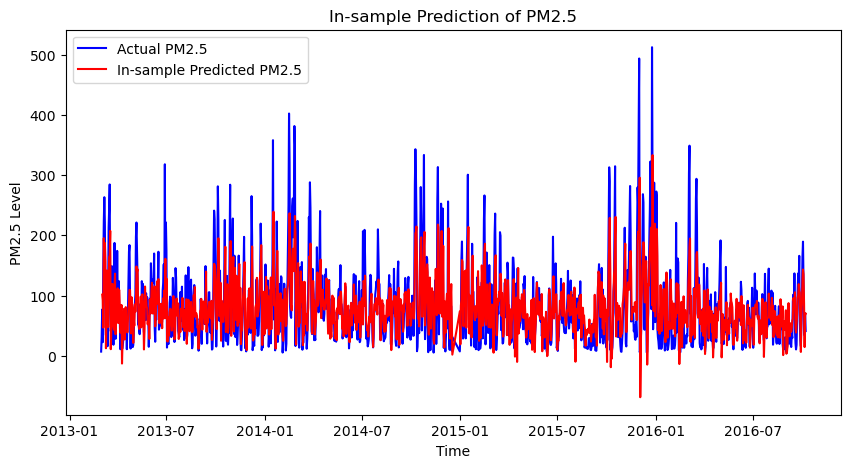

In [53]:
# In-sample prediction
in_sample_pred = var_model_fitted.fittedvalues

# Plot in-sample predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['PM2.5'], label='Actual PM2.5', color='blue')
plt.plot(in_sample_pred.index, in_sample_pred['PM2.5'], label='In-sample Predicted PM2.5', color='red')
plt.legend()
plt.title('In-sample Prediction of PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Level')
plt.show()

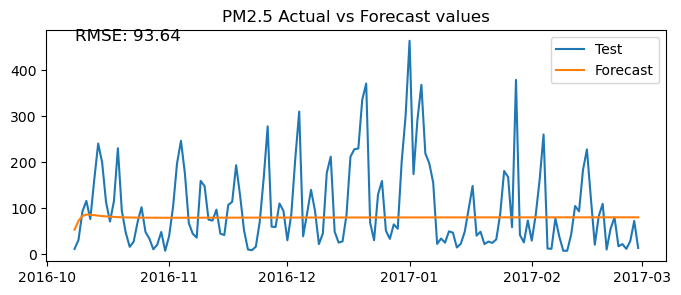

In [54]:
plot_actual_vs_forecast(test, forecast_df, target='PM2.5')

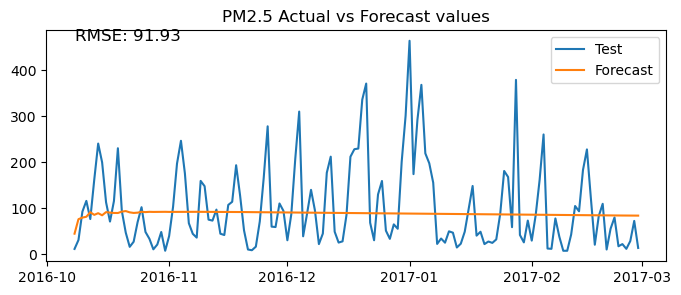

In [55]:
model = VAR(train)
# Fit the VAR model using the selected lag 
selected_lag = 11
var_model_fitted = model.fit(selected_lag)
# Forecast using the fitted model
forecast_values = var_model_fitted.forecast(train.values[-selected_lag:], steps=len(test)) # initial values are the last laged values of the train set
forecast_df = pd.DataFrame(forecast_values, index=test.index, columns=train.columns)

plot_actual_vs_forecast(test, forecast_df, target='PM2.5')

#### Optional Exercises
- Conduct residual diagnostics to verify the accuracy of the forecast - Optional exercise
- Automated Lag Order Selection- Optional exercise
- Explore forecast with the confidence intervals and plot it

## VECM- Vector Error Correction Model 

In [56]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

### Johansen cointegration test

#### Test cointegration of each variable against the target

In [62]:
# Iterate through each potential predictor variable to test cointegration with PM2.5 individually
data_set = data_daily
traget_variable = 'PM2.5'
selected_predictors_for_vecm = [traget_variable]  # Start with PM2.5 as the base for VECM

for column in data_set.columns:
    if column != traget_variable:
        # Perform Johansen cointegration test between PM2.5 and the current column
        cointegration_test_data = data_set[[traget_variable, column]]
        result = coint_johansen(cointegration_test_data, det_order=-1, k_ar_diff=10)
        print(f'Column: {column}')
        print('Trace Statistic:', result.lr1[0])
        print('Critical Value (95%):', result.cvt[0, 1])
        
        # Check if a cointegration relationship is present (trace statistic > critical value at 5% level)
        if result.lr1[0] > result.cvt[0, 1]:  # tests if the trace statistic is greater than the critical value at 95% level
            selected_predictors_for_vecm.append(column)
            print(f'Cointegration between PM2.5 and {column} is present')
        else:
            print(f'Cointegration between PM2.5 and {column} is not present')
        print('\n')
print(f'Selected Predictors for VECM based on Cointegration: {selected_predictors_for_vecm}')

# Prepare the dataset for VECM with the selected predictors
vecm_data = data_set[selected_predictors_for_vecm]


Column: PM10
Trace Statistic: 61.36046387930987
Critical Value (95%): 12.3212
Cointegration between PM2.5 and PM10 is present


Column: SO2
Trace Statistic: 40.18786350558089
Critical Value (95%): 12.3212
Cointegration between PM2.5 and SO2 is present


Column: NO2
Trace Statistic: 103.60147819842379
Critical Value (95%): 12.3212
Cointegration between PM2.5 and NO2 is present


Column: CO
Trace Statistic: 48.104636944700616
Critical Value (95%): 12.3212
Cointegration between PM2.5 and CO is present


Column: O3
Trace Statistic: 32.09285299471949
Critical Value (95%): 12.3212
Cointegration between PM2.5 and O3 is present


Column: TEMP
Trace Statistic: 22.553884098851878
Critical Value (95%): 12.3212
Cointegration between PM2.5 and TEMP is present


Column: PRES
Trace Statistic: 85.50040093401479
Critical Value (95%): 12.3212
Cointegration between PM2.5 and PRES is present


Column: DEWP
Trace Statistic: 15.864040640928666
Critical Value (95%): 12.3212
Cointegration between PM2.5 and DE

#### Test cointegration of entire selected predictors data set

In [60]:
selected_predictors= ['NO2', 'O3', 'PRES', 'DEWP', 'WSPM']

In [61]:
# Johansen cointegration test to check cointegration between target variable PM2.5 and all other variables in data_daily
cointegration_data = data_daily[['PM2.5'] + selected_predictors]
# Perform Johansen cointegration test
result = coint_johansen(cointegration_data, det_order=-1, k_ar_diff=selected_lag)
print(f'Trace Statistic: {result.lr1}')
print(f'\nCritical Value: {result.cvt}')


Trace Statistic: [2.84659857e+02 1.78221967e+02 1.04069546e+02 4.97944550e+01
 1.02549344e+01 6.55510066e-03]

Critical Value: [[79.5329 83.9383 92.7136]
 [56.2839 60.0627 67.6367]
 [37.0339 40.1749 46.5716]
 [21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]


In [63]:
# Interpret Johansen test results
for i in range(len(result.lr1)):
    if result.lr1[i] > result.cvt[i, 1]:  # Compare with 95% critical value
        print(f'Cointegration relationship found at rank {i+1}')
    else:
        print(f'No cointegration relationship found at rank {i+1}')



Cointegration relationship found at rank 1
No cointegration relationship found at rank 2


##### Cointegration test to determine the number of cointegrating relationships including all set of variables
Cointegration Relationship Found at Rank 1 to Rank 4
- This means that the test has identified 4 cointegrating vectors of long-term equilibrium relationships
- In simpler terms, there are 4 unique ways in which these variables move together over the long term
- For modeling with VECM, a rank of 4 suggests that you should include 4 cointegrating vectors in the model 

### Fit the VECM model using the selected variables

Det. terms outside the coint. relation & lagged endog. parameters for equation NO2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.NO2        -0.2302      0.074     -3.130      0.002      -0.374      -0.086
L1.O3          0.1985      0.044      4.546      0.000       0.113       0.284
L1.PRES        0.2789      0.170      1.640      0.101      -0.054       0.612
L1.DEWP       -0.7938      0.230     -3.445      0.001      -1.245      -0.342
L1.WSPM       -9.9173      2.439     -4.067      0.000     -14.697      -5.137
L1.PM2.5       0.0310      0.029      1.083      0.279      -0.025       0.087
L2.NO2        -0.3596      0.073     -4.914      0.000      -0.503      -0.216
L2.O3          0.0435      0.044      0.997      0.319      -0.042       0.129
L2.PRES        0.0702      0.171      0.411      0.681      -0.265       0.405
L2.DEWP       -0.2329      0.236     -0.989     

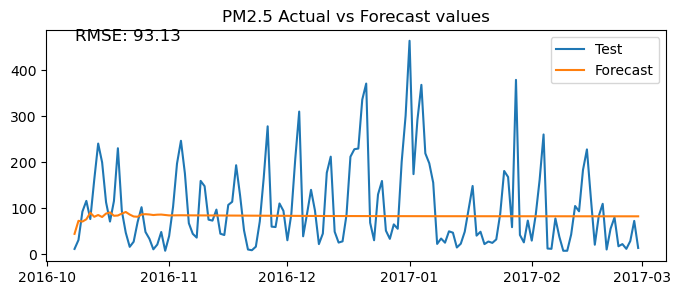

In [64]:
# Fit the VECM model using the selected variables
vecm_model = VECM(train, coint_rank=4, k_ar_diff=selected_lag)
vecm_fitted = vecm_model.fit()

# Summary of the VECM model
print(vecm_fitted.summary())

# Forecast using the fitted VECM model
forecast_values_vecm = vecm_fitted.predict(steps=len(test))
forecast_df_vecm = pd.DataFrame(forecast_values_vecm, index=test.index, columns=train.columns)

plot_actual_vs_forecast(test, forecast_df= forecast_df_vecm, target='PM2.5')

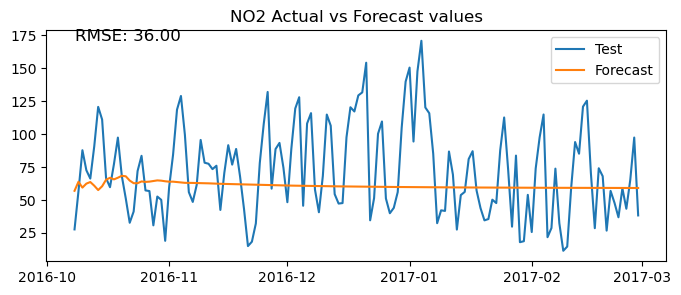

In [65]:
plot_actual_vs_forecast(test, forecast_df= forecast_df_vecm, target='NO2')

## ARIMAX- ARIMA with Exogenous Variables

In [66]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [67]:
# function to plot the forecast vs actuals (test) values and calculate the RMSE
def plot_arimax_forcast(train, test, forecast, plot_train=True): 
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'ARIMA RMSE: {rmse:.2f}')

    # Plot the results
    plt.figure(figsize=(8, 4))
    if plot_train:
        plt.plot(train.index, train, label='Train Data')
    plt.plot(test.index, test, label='Test Data', color='gray')
    plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
    plt.title('Forecast vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # print the rmse on the plot
    plt.text(test.index.max(), test.max(), f'RMSE: {rmse:.2f}', fontsize=12)
    
    plt.show()

### Prepare the data

In [68]:
# Define target and exogenous variables (climate features as exogenous variables)
target_variable = 'PM2.5'
exogenous_variables = ['TEMP', 'DEWP', 'PRES', 'WSPM', 'RAIN']

In [69]:
# split to train and test
train, test, test_size = split_data(data_daily, test_prop=0.1)

# Define target and exogenous for training and testing
y_train = train[target_variable]
x_train = train[exogenous_variables]
y_test = test[target_variable]
x_test = test[exogenous_variables]

train shape: (1302, 11)
test shape: (144, 11)
split Date: 2016-10-07 00:00:00


### Select initial p,d,q parametrs

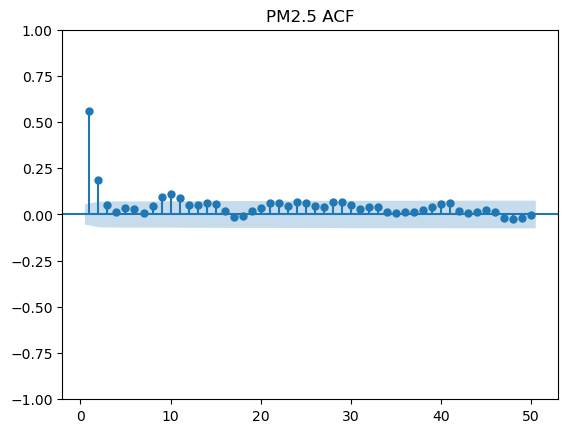

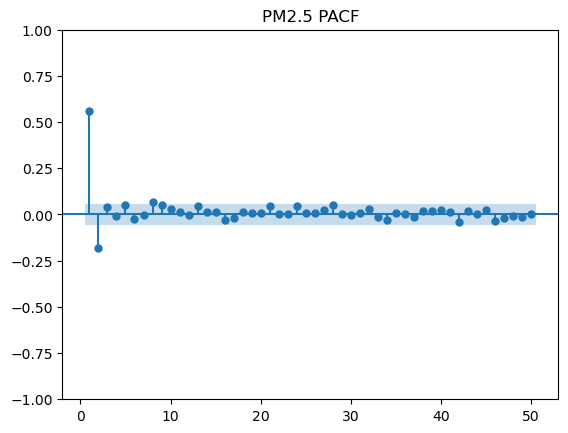

In [70]:
# Plot ACF and PACF for PM2.5
plot_acf(y_train, lags=50, zero=False)
plt.title('PM2.5 ACF')
plt.show()

plot_pacf(y_train, lags=50, zero=False)
plt.title('PM2.5 PACF')
plt.show()

#### Initial order selection p = 2, d = 0, q =2

### Fit an ARIMAX model

In [71]:
order = (10, 0, 10)  # Example parameters (p, d, q)
model_arimax = ARIMA(y_train, order=order, exog=x_train)
arimax_fitted = model_arimax.fit()
print(arimax_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1302
Model:               ARIMA(10, 0, 10)   Log Likelihood               -6832.981
Date:                Tue, 29 Oct 2024   AIC                          13719.962
Time:                        22:08:23   BIC                          13859.597
Sample:                             0   HQIC                         13772.350
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2186.7149    394.102      5.549      0.000    1414.289    2959.141
TEMP          -7.7974      0.559    -13.937      0.000      -8.894      -6.701
DEWP           5.2221      0.468     11.162      0.0

### Forecasting Using ARIMAX
- Forecast using the fitted model, and provide the **exogenous variables** for the forecast period.

ARIMA RMSE: 68.33


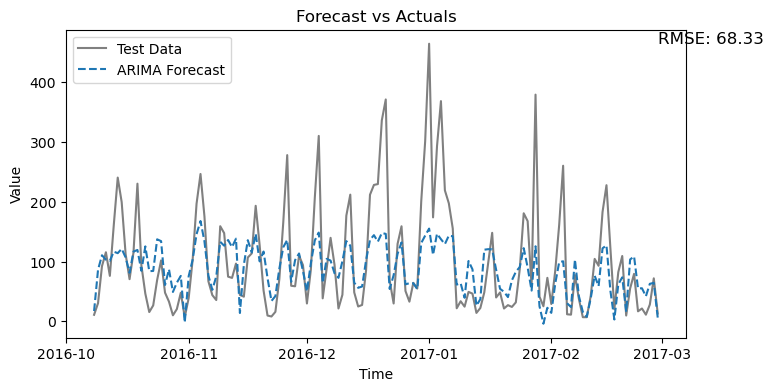

In [72]:
# Forecast on test set using exogenous variables
forecast = arimax_fitted.forecast(steps=len(y_test), exog=x_test)

plot_arimax_forcast(y_train, y_test, forecast, plot_train=False)

#### Compare to simple ARIMA

ARIMA RMSE: 93.96


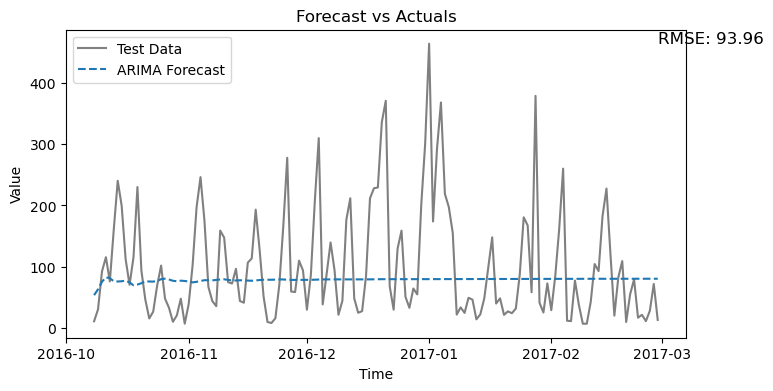

In [73]:
order = (10, 0, 10)  # parameters (p, d, q)
model_arima = ARIMA(y_train, order=order)
arima_fitted = model_arima.fit()
# print(arima_fitted.summary())
# Forecast on test set using exogenous variables
forecast = arima_fitted.forecast(steps=len(y_test))
plot_arimax_forcast(y_train, y_test, forecast, plot_train=False)